In [1]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/langevin/langevin/dev/flopy3fork.git/flopy


In [2]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [3]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


In [4]:
def get_seawat_model(ws, name, nlay=10, ncol=20, qinflow=5.7024,
                     constant_concentration=False,
                     ctimes=None, cidx=None, verbosity_level=1):
    lx = 2.
    lz = 1.
    nrow = 1
    nper = 1
    delr = lx / ncol
    delc = 1.
    top = 1.
    delz = lz / nlay
    botm = list(top - np.arange(delz, nlay * delz + delz, delz))

    perlen = 0.5
    nstp = [500]
    tsmult = [1.]
    steady = [True]

    swt = flopy.seawat.Seawat(name, exe_name='swt_v4', model_ws=ws, )
    dis = flopy.modflow.ModflowDis(swt, nlay, nrow, ncol, nper=1, delr=delr,
                                   delc=delc, laycbd=0, top=top, botm=botm, 
                                   perlen=perlen, nstp=1, steady=steady)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
    ibound[:, :, -1] = -1
    bas = flopy.modflow.ModflowBas(swt, ibound, 1)
    lpf = flopy.modflow.ModflowLpf(swt, hk=864., vka=864.)
    pcg = flopy.modflow.ModflowPcg(swt, hclose=1.e-8)
    oc = flopy.modflow.ModflowOc(swt, 
                                 stress_period_data={(0, 0): ['save head', 'save budget']},
                                 compact=True)
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    wel_data = {}
    ssm_data = {}
    wel_sp1 = []
    ssm_sp1 = []
    for k in range(nlay):
        wel_sp1.append([k, 0, 0, qinflow / nlay])
        ssm_sp1.append([k, 0, 0, 0., itype['WEL']])
        ssm_sp1.append([k, 0, ncol - 1, 35., itype['BAS6']])
    wel_data[0] = wel_sp1
    ssm_data[0] = ssm_sp1
    wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data)
    if constant_concentration:
        icbund = ibound
    else:
        icbund = 1
    btn = flopy.mt3d.Mt3dBtn(swt, icbund=icbund, nprs=-5, prsity=0.35, sconc=35., ifmtcn=0,
                             chkmas=False, nprobs=10, nprmas=10, dt0=perlen/500.)
    adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)
    dsp = flopy.mt3d.Mt3dDsp(swt, al=0., trpt=1., trpv=1., dmcoef=0.57024)
    gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
    ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)

    vdf = flopy.seawat.SeawatVdf(swt, iwtable=0, densemin=0, densemax=0,
                                 denseref=1000., denseslp=0.7, firstdt=perlen/500.)
    
    swt.write_input()
    v = swt.run_model(silent=True, report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
        
    fname = os.path.join(ws, 'MT3D001.UCN')
    concobj = flopy.utils.UcnFile(fname)
    clist = None
    cts = None
    if ctimes is not None:
        times = concobj.get_times()
        clist = []
        for t in ctimes:
            if isinstance(t, str):
                if t.upper() == 'LAST':
                    tt = times[-1]
                    conc = concobj.get_data(totim=tt)
            else:
                conc = concobj.get_data(totim=t)
            clist.append(conc)
    if cidx is not None:
        cts = concobj.get_ts(cidx)
    concobj.file.close()

    return swt, clist, cts

In [5]:
def get_model(ws, name, nlay=10, ncol=20, qinflow=5.7024,
              single_matrix=False, hhformulation=True,
              constant_concentration=False, cstrt=35.,
              ctimes=None, cidx=None, sptimes=None, verbosity_level=1):

    lx = 2.
    lz = 1.

    nrow = 1
    #nlay = 10
    #ncol = 20
    nper = 1
    delr = lx / ncol
    delc = 1.
    top = 1.
    delz = lz / nlay
    botm = list(top - np.arange(delz, nlay * delz + delz, delz))

    perlen = [0.5]
    nstp = [500]
    tsmult = [1.]
    steady = [True]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

    # This should be changed to one true and one false after scott fixes
    # flopy.
    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-7, 1e-5, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name

    gwf = flopy.mf6.MFModel(sim, model_type='gwf6', modelname=gwfname,
                            model_nam_file='{}.nam'.format(gwfname))

    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(gwfname))
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    ic = flopy.mf6.ModflowGwfic(gwf, strt=1.)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=0,
                                  k=864.)

    hhoptions = False
    if hhformulation:
        hhoptions = [('HHFORMULATION'), ]
        #hhoptions.append(('LHS'))
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions)

    def chd_value(k):
        f = 0.0245
        if hhformulation:
            f = 0.
        depth = k * delz + 0.5 * delz
        hf = top + f * depth
        return hf

    # chd files
    chdlist1 = []
    for k in range(nlay):
        chdlist1.append([(k, 0, ncol - 1), chd_value(k), 35.])
    chd1 = flopy.mf6.ModflowGwfchd(gwf,
                                   stress_period_data=chdlist1,
                                   print_input=True,
                                   print_flows=True,
                                   save_flows=False,
                                   pname='CHD-1',
                                   auxiliary='CONCENTRATION',
                                   filename='{}.chd'.format(gwfname))

    wellist1 = []
    qwell = qinflow / nlay
    for k in range(nlay):
        wellist1.append([(k, 0, 0), qwell, 0.])
    wel1 = flopy.mf6.ModflowGwfwel(gwf,
                                   stress_period_data=wellist1,
                                   print_input=True,
                                   print_flows=True,
                                   save_flows=False,
                                   pname='WEL-1',
                                   auxiliary='CONCENTRATION',
                                   filename='{}.wel'.format(gwfname))

    # output control
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')],
                                printrecord=[('HEAD', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                      outer_hclose=hclose,
                                      outer_maximum=nouter,
                                      under_relaxation='NONE',
                                      inner_maximum=ninner,
                                      inner_hclose=hclose, rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    ic = flopy.mf6.ModflowGwtic(gwt, strt=cstrt,
                                filename='{}.ic'.format(gwtname))

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM',
                                  filename='{}.adv'.format(gwtname))

    # dispersion
    diffc = 0.57024
    dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=diffc,
                                  # alh=0., alv=0., ath=0., atv=0.,
                                  filename='{}.dsp'.format(gwtname))

    # mass storage and transfer
    porosity = 0.35
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity,
                                  filename='{}.sto'.format(gwtname))

    # sources
    sourcerecarray = [('CHD-1', 'AUX', 'CONCENTRATION'),
                      ('WEL-1', 'AUX', 'CONCENTRATION')]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                  filename='{}.ssm'.format(gwtname))
    
    # constant concentration
    if constant_concentration:
        cnclist = []
        for k in range(nlay):
            cnclist.append([(k, 0, ncol - 1), 35.])
        cnc = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cnclist)

    # output control
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=[('CONCENTRATION', 'ALL')],
                                printrecord=[('CONCENTRATION', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    sim.write_simulation()
    v = sim.run_simulation(report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
    
    fname = os.path.join(ws, 'gwt_' + name + '.ucn')
    concobj = flopy.utils.HeadFile(fname, text='concentration', precision='double')
    clist = None
    cts = None
    if ctimes is not None:
        times = concobj.get_times()
        clist = []
        for t in ctimes:
            if isinstance(t, str):
                if t.upper() == 'LAST':
                    tt = times[-1]
                    conc = concobj.get_data(totim=tt)
            else:
                conc = concobj.get_data(totim=t)
            clist.append(conc)
    if cidx is not None:
        cts = concobj.get_ts(cidx)
    concobj.file.close()

    fname = os.path.join(ws, 'gwf_' + name + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname, precision='double')
    splist = None
    if sptimes is not None:
        times = budobj.get_times()
        splist = []
        for t in sptimes:
            if isinstance(t, str):
                if t.upper() == 'LAST':
                    tt = times[-1]
                    spdis = budobj.get_data(totim=tt, text='DATA-SPDIS')[0]
            else:
                spdis = budobj.get_data(totim=t, text='DATA-SPDIS')[0]
            splist.append(spdis)    
    
    return sim, clist, cts, splist

In [6]:
levels = [0.01, .1, .5, .9, .99]

## MODFLOW 6 Hydraulic Head Formulation

 Elapsed run time:  4.791 Seconds

 Normal termination of simulation.


Text(0.5, 1.0, 'MODFLOW 6 HYDRAULIC HEAD FORMULATION')

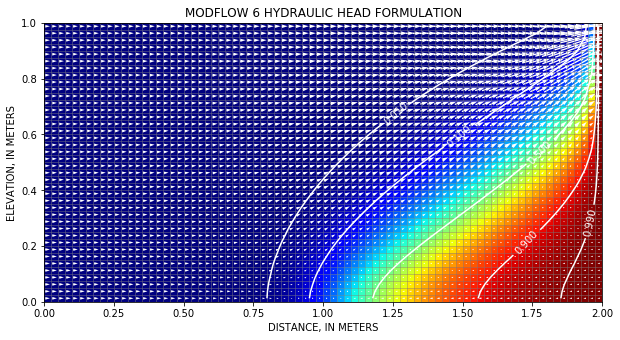

In [7]:
# Hydraulic Head formulation
ws = 'temp/pxx_henry_HH'
name = 'henry'
sim, clist, cts, splist = get_model(ws, name, nlay=40, ncol=80,
                                    hhformulation=True,
                                    verbosity_level=0, cstrt=35.,
                                    constant_concentration=True,
                                    ctimes=['last'], sptimes=['last'])
mf6hhconc = clist[0]
gwf = sim.get_model('gwf_' + name)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0})
xs.plot_grid(linewidths=0.5, alpha=0.5)
xs.plot_array(clist[0], cmap='jet', vmin=0, vmax=35)
xs.plot_specific_discharge(splist[0], color='white')
cs = xs.contour_array(clist[0] / 35., levels=levels, colors='white')
ax.clabel(cs)
ax.set_xlabel('DISTANCE, IN METERS')
ax.set_ylabel('ELEVATION, IN METERS')
ax.set_title('MODFLOW 6 HYDRAULIC HEAD FORMULATION')

## MODFLOW 6 EFH Formulation

 Elapsed run time:  3.842 Seconds

 Normal termination of simulation.


Text(0.5, 1.0, 'MODFLOW 6 EQUIVALENT FRESHWATER HEAD FORMULATION')

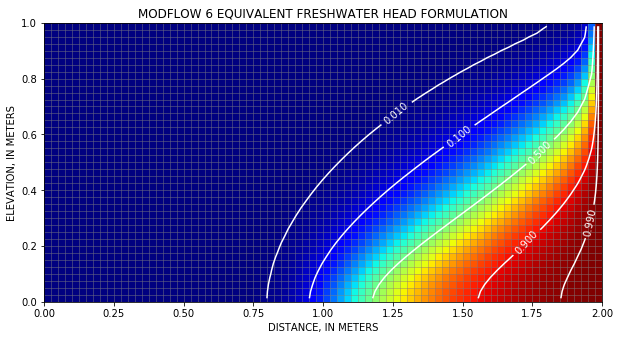

In [8]:
# Freshwater Head formulation
ws = 'temp/pxx_henry_EFH'
name = 'henry'
sim, clist, cts, splist = get_model(ws, name, nlay=40, ncol=80,
                                    verbosity_level=0,
                                    hhformulation=False,
                                    constant_concentration=True,
                                    ctimes=['last'], sptimes=['last'])
mf6efhconc = clist[0]
gwf = sim.get_model('gwf_' + name)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0})
xs.plot_grid(linewidths=0.5, alpha=0.5)
xs.plot_array(clist[0], cmap='jet', vmin=0, vmax=35)
cs = xs.contour_array(clist[0] / 35., levels=levels, colors='white')
ax.clabel(cs)
ax.set_xlabel('DISTANCE, IN METERS')
ax.set_ylabel('ELEVATION, IN METERS')
ax.set_title('MODFLOW 6 EQUIVALENT FRESHWATER HEAD FORMULATION')

## SEAWAT EFH Formulation

 Elapsed run time:  3.835 Seconds

 Normal termination of SEAWAT


Text(0.5, 1.0, 'SEAWAT')

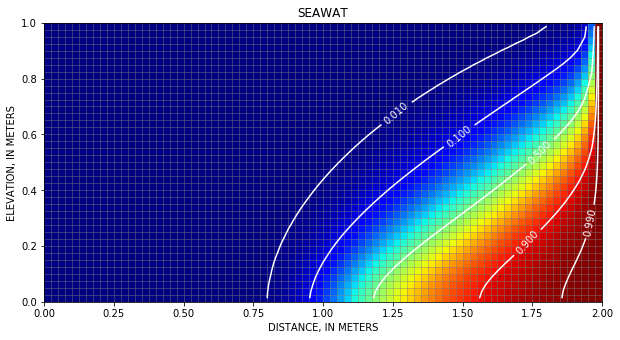

In [9]:
# SEAWAT model
ws = 'temp/pxx_henry_seawat'
name = 'henry'
swt, clist, cts = get_seawat_model(ws, name, nlay=40, ncol=80, 
                                   constant_concentration=True,
                                   ctimes=['last'])
seawatconc = clist[0]
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xs = flopy.plot.PlotCrossSection(swt, line={'row': 0})
xs.plot_grid(linewidths=0.5, alpha=0.5)
xs.plot_array(clist[0], cmap='jet', vmin=0, vmax=35)
cs = xs.contour_array(clist[0] / 35., levels=levels, colors='white')
ax.clabel(cs)
ax.set_xlabel('DISTANCE, IN METERS')
ax.set_ylabel('ELEVATION, IN METERS')
ax.set_title('SEAWAT')

## MODFLOW 6 Hydraulic Head Formulation (modified Henry)

 Elapsed run time:  5.361 Seconds

 Normal termination of simulation.


Text(0.5, 1.0, 'MODFLOW 6 HYDRAULIC HEAD FORMULATION')

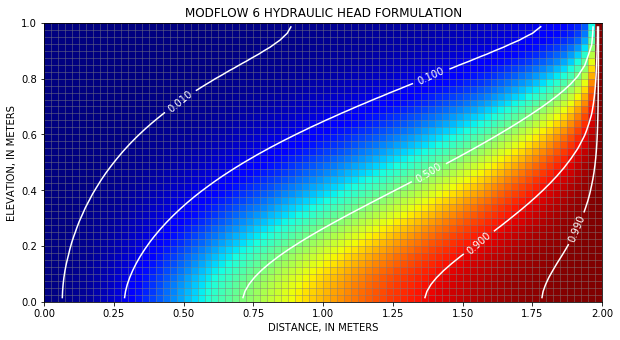

In [10]:
# Hydraulic Head formulation
ws = 'temp/pxx_henry_HHm'
name = 'henry'
sim, clist, cts, splist = get_model(ws, name, nlay=40, ncol=80, qinflow=5.7024/2.,
                                    hhformulation=True,
                                    verbosity_level=0,
                                    constant_concentration=True,
                                    ctimes=['last'], sptimes=['last'])
mf6hhconcm = clist[0]
gwf = sim.get_model('gwf_' + name)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0})
xs.plot_grid(linewidths=0.5, alpha=0.5)
xs.plot_array(clist[0], cmap='jet', vmin=0, vmax=35)
cs = xs.contour_array(clist[0] / 35., levels=levels, colors='white')
ax.clabel(cs)
ax.set_xlabel('DISTANCE, IN METERS')
ax.set_ylabel('ELEVATION, IN METERS')
ax.set_title('MODFLOW 6 HYDRAULIC HEAD FORMULATION')

## MODFLOW 6 EFH Formulation (modified Henry)

 Elapsed run time:  4.440 Seconds

 Normal termination of simulation.


Text(0.5, 1.0, 'MODFLOW 6 HYDRAULIC HEAD FORMULATION')

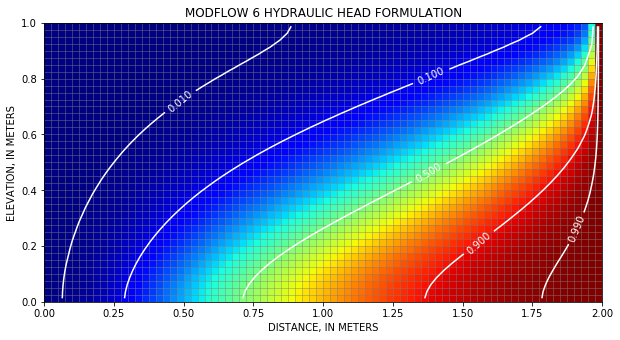

In [11]:
# Hydraulic Head formulation
ws = 'temp/pxx_henry_EFHm'
name = 'henry'
sim, clist, cts, splist = get_model(ws, name, nlay=40, ncol=80, qinflow=5.7024/2.,
                                    hhformulation=False,
                                    verbosity_level=0,
                                    constant_concentration=True,
                                    ctimes=['last'], sptimes=['last'])
mf6efhconcm = clist[0]
gwf = sim.get_model('gwf_' + name)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0})
xs.plot_grid(linewidths=0.5, alpha=0.5)
xs.plot_array(clist[0], cmap='jet', vmin=0, vmax=35)
cs = xs.contour_array(clist[0] / 35., levels=levels, colors='white')
ax.clabel(cs)
ax.set_xlabel('DISTANCE, IN METERS')
ax.set_ylabel('ELEVATION, IN METERS')
ax.set_title('MODFLOW 6 HYDRAULIC HEAD FORMULATION')

## SEAWAT EFH Formulation (modified Henry)

 Elapsed run time:  4.408 Seconds

 Normal termination of SEAWAT


Text(0.5, 1.0, 'SEAWAT')

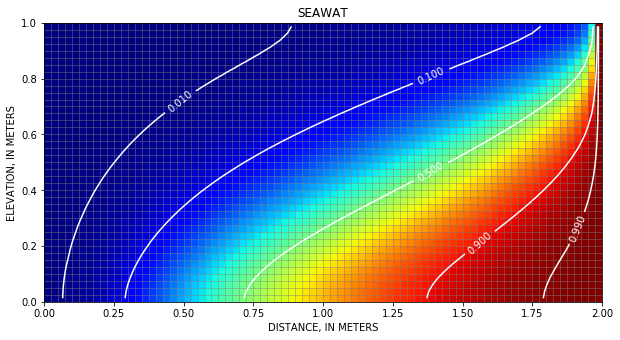

In [12]:
# SEAWAT model
ws = 'temp/pxx_henry_seawatm'
name = 'henry'
swt, clist, cts = get_seawat_model(ws, name, nlay=40, ncol=80, qinflow=5.7024/2.,
                                   constant_concentration=True,
                                   ctimes=['last'])
seawatconcm = clist[0]
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xs = flopy.plot.PlotCrossSection(swt, line={'row': 0})
xs.plot_grid(linewidths=0.5, alpha=0.5)
xs.plot_array(clist[0], cmap='jet', vmin=0, vmax=35)
cs = xs.contour_array(clist[0] / 35., levels=levels, colors='white')
ax.clabel(cs)
ax.set_xlabel('DISTANCE, IN METERS')
ax.set_ylabel('ELEVATION, IN METERS')
ax.set_title('SEAWAT')

## MODFLOW 6 HH Versus SEAWAT EFH

inwidth 3.248031496062992


/Users/langevin/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


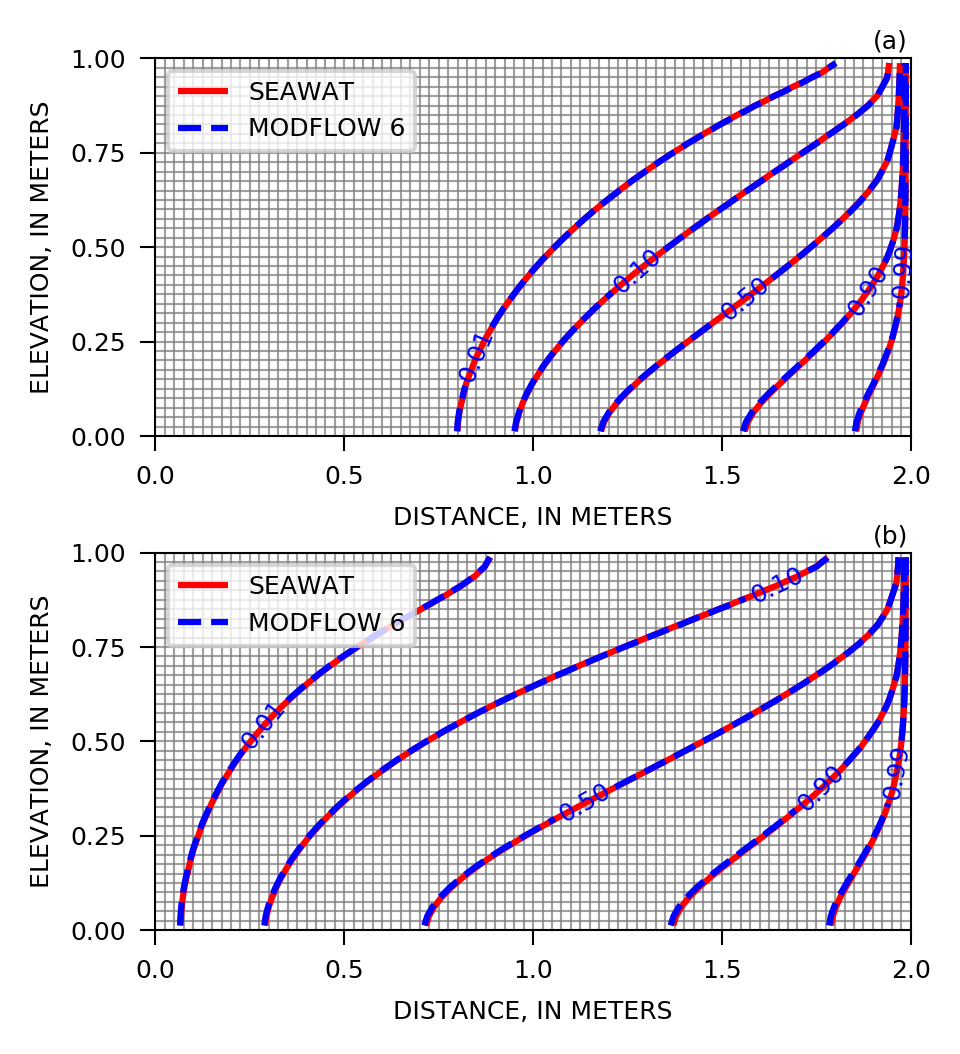

In [13]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, .5, 1., 1.5, 2.])
    ax.set_yticks([0, .25, .5, .75, 1])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 4.0), dpi=300)

# comparison
ax = fig.add_subplot(2, 1, 1, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(swt, line={'row': 0}, ax=ax)
xs.plot_grid(linewidths=0.5, alpha=0.5)
cs_swt = xs.contour_array(seawatconc / 35., levels=levels, colors='red')
cs_mf6 = xs.contour_array(mf6hhconc / 35., levels=levels, colors='blue', linestyles='--')
ax.clabel(cs_mf6, fontsize=6, fmt='%1.2f')
h1, _ = cs_swt.legend_elements()
h2, _ = cs_mf6.legend_elements()
ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
ax.legend([h1[0], h2[0]], ['SEAWAT', 'MODFLOW 6'], loc=2, fontsize=6)
ax.text(1.9, 1.025, '(a)', fontsize=6)

ax = fig.add_subplot(2, 1, 2, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(swt, line={'row': 0}, ax=ax)
xs.plot_grid(linewidths=0.5, alpha=0.5)
cs_swt = xs.contour_array(seawatconcm / 35., levels=levels, colors='red')
cs_mf6 = xs.contour_array(mf6hhconcm / 35., levels=levels, colors='blue', linestyles='--')
ax.clabel(cs_mf6, fontsize=6, fmt='%1.2f')
h1, _ = cs_swt.legend_elements()
h2, _ = cs_mf6.legend_elements()
ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
ax.legend([h1[0], h2[0]], ['SEAWAT', 'MODFLOW 6'], loc=2, fontsize=6)
ax.text(1.9, 1.025, '(b)', fontsize=6)

fname = '../Figures/pxx_henry.pdf'
plt.savefig(fname, bbox_inches='tight')

## MODFLOW 6 EFH Versus SEAWAT EFH

inwidth 3.248031496062992


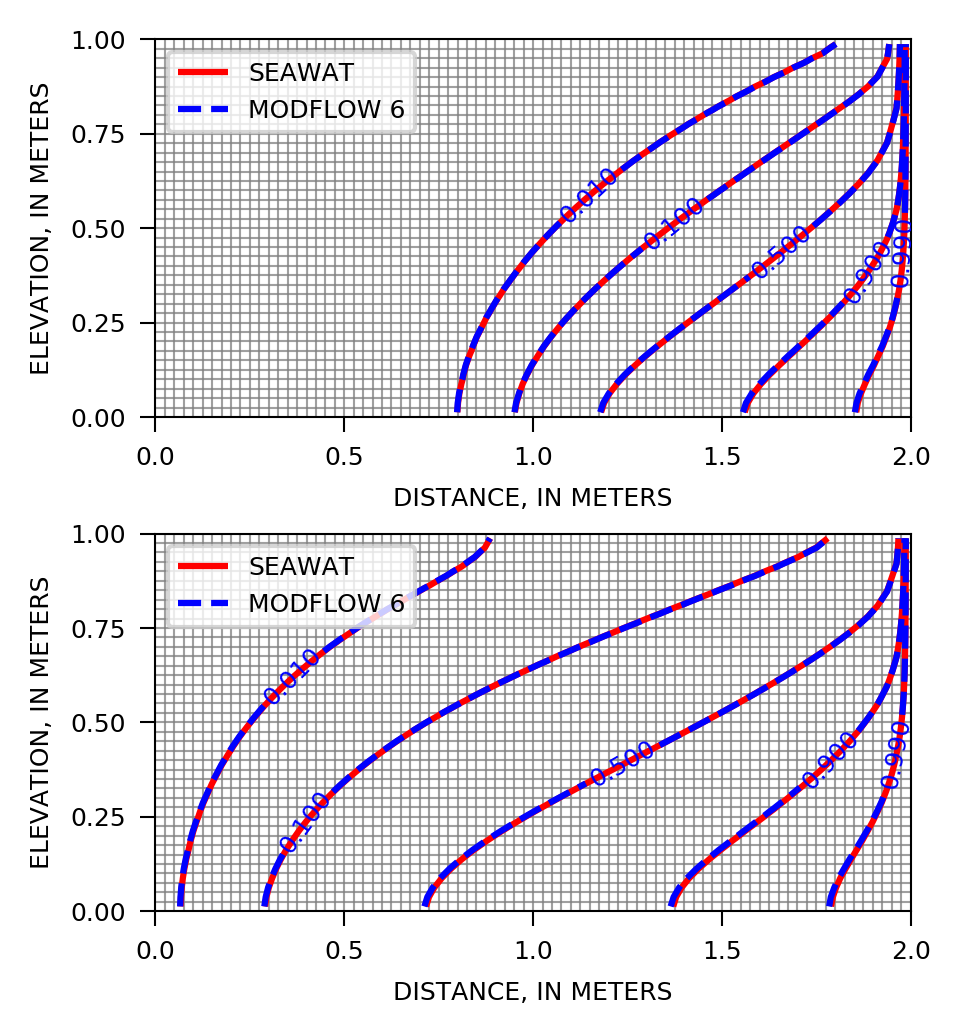

In [14]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, .5, 1., 1.5, 2.])
    ax.set_yticks([0, .25, .5, .75, 1])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 4), dpi=300)

# comparison
ax = fig.add_subplot(2, 1, 1, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(swt, line={'row': 0}, ax=ax)
xs.plot_grid(linewidths=0.5, alpha=0.5)
cs_swt = xs.contour_array(seawatconc / 35., levels=levels, colors='red')
cs_mf6 = xs.contour_array(mf6efhconc / 35., levels=levels, colors='blue', 
                          linestyles='--')
ax.clabel(cs_mf6, fontsize=6)
h1, _ = cs_swt.legend_elements()
h2, _ = cs_mf6.legend_elements()
ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
ax.legend([h1[0], h2[0]], ['SEAWAT', 'MODFLOW 6'], loc=2, fontsize=6)

ax = fig.add_subplot(2, 1, 2, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(swt, line={'row': 0}, ax=ax)
xs.plot_grid(linewidths=0.5, alpha=0.5)
cs_swt = xs.contour_array(seawatconcm / 35., levels=levels, colors='red')
cs_mf6 = xs.contour_array(mf6efhconcm / 35., levels=levels, colors='blue', linestyles='--')
ax.clabel(cs_mf6, fontsize=6)
h1, _ = cs_swt.legend_elements()
h2, _ = cs_mf6.legend_elements()
ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
ax.legend([h1[0], h2[0]], ['SEAWAT', 'MODFLOW 6'], loc=2, fontsize=6)

fname = '../Figures/pxx_henry_efh.pdf'
#plt.savefig(fname)

## Boundary Condition Plot

In [15]:
def get_patch_collection(modelgrid, ibd, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    botm = modelgrid.botm
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            if ibd[k, j] == 1:
                x0 = xv[0, j]
                x1 = xv[0, j + 1]
                z0 = zv[k, 0, j]
                z1 = zv[k + 1, 0, j]
                poly = [[x0, z0], [x1, z0], [x1, z1], [x0, z1], [x0, z0]]
                #print(poly)
                patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
                patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True)
    return pc

inwidth 3.248031496062992


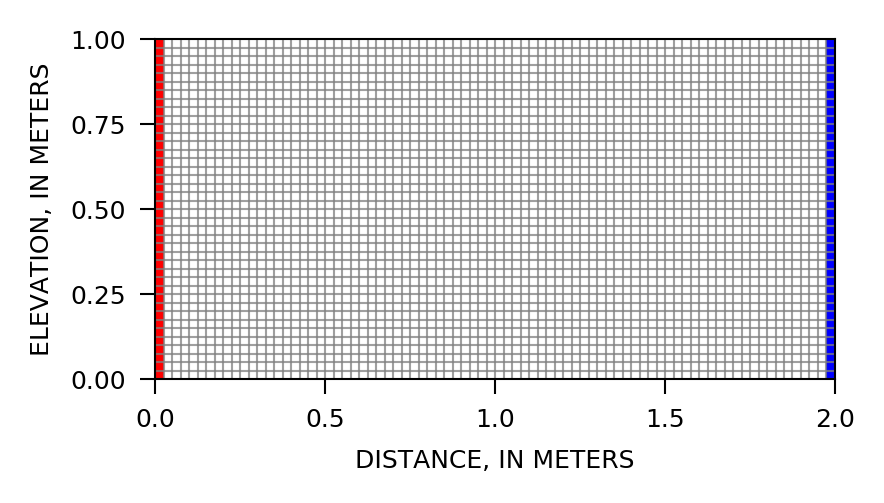

In [16]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, .5, 1., 1.5, 2.])
    ax.set_yticks([0, .25, .5, .75, 1])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 1.5), dpi=300)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax_formatter(ax)

gwf = sim.get_model('gwf_' + name)
modelgrid = gwf.modelgrid
nlay = modelgrid.nlay
ncol = modelgrid.ncol

ibd = np.zeros((nlay, ncol), dtype=np.int)
ibd[:, 0] = 1
pc_well = get_patch_collection(modelgrid, ibd, ec='none', fc='red')

ibd = np.zeros((nlay, ncol), dtype=np.int)
ibd[:, -1] = 1
pc_chd = get_patch_collection(modelgrid, ibd, ec='none', fc='blue')

xs = flopy.plot.PlotCrossSection(swt, line={'row': 0}, ax=ax)
xs.plot_grid(linewidths=0.5, alpha=0.5)
pcw = ax.add_collection(pc_well)
pcc = ax.add_collection(pc_chd)
ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
#ax.legend([pcw, pcc], ['Freshwater Inflow', 'Seawater Hydrostatic Conditions'])
fname = '../Figures/pxx_henry_bcs.pdf'
plt.savefig(fname)